# Transfer Learning

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

**Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

**Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

## Data Preparation

Data preparation is the process of cleaning and transforming raw data to processing and analysis. It is an important step to processing and often involves reformatting data, making corrections to data and the combining of data sets to enrich data.

In this tutorial, you will use a large set of images of cats and dogs. There are 1738 corrupted images that are dropped. This dataset is extracted from the available datasets of tensorflow. You can learn more about loading images here https://www.tensorflow.org/datasets

In [ ]:
# import needed libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (96, 96)

In [ ]:
# Construct a tf.data.Dataset
ds = tfds.load('cats_vs_dogs', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteY64UYO/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
row = next(iter(ds))
print("Max: ", tf.reduce_max(row['image']))
print("Min: ", tf.reduce_min(row['image']))
print("Shape: ", row['image'].shape)

Max:  tf.Tensor(255, shape=(), dtype=uint8)
Min:  tf.Tensor(0, shape=(), dtype=uint8)
Shape:  (268, 288, 3)


### Resize and Normalization
You have to consider that the pretrained neural network accepts a given `size` images and a given `normalization`. Here, you update this parts according the network needs.

Normalization is the process of converting a random sized image into a standard size. To bring all characters into a common size platform in order to extract features on the same footing

In [ ]:
# Resize and Normalize according to neural network settings
def transform_images(row, size):
    # resize images
    image = tf.image.resize(row['image'], size)
    # normalize or rescale to [-1, 1] 
    # it depends to the neural network used
    # [0, 255.0]
    # image = (image  / 127.5) - 1

    image = tf.keras.applications.vgg16.preprocess_input(image)

    return image, row['label']

ds = ds.map(lambda row:transform_images(row, IMG_SIZE))
#ds = ds.batch(BATCH_SIZE)

In [ ]:
#@title What is the functionality of 'preprocess_input'?

#"Image" argument is a floating point numpy.array or a tf.Tensor, 
#3D or 4D with 3 color channels, with values in the range [0, 255]. 
#The preprocessed data are written over the input data if the data 
#types are compatible. 






In [ ]:
#@title What is a lambda function at python?
#Lambda Function, also referred to as ‘Anonymous function’ is same as
#a regular python function but can be defined without a name.
#Example:
# calculate squares using lambda
squares = lambda x: x*x
print('Using lambda: ', squares(5))

Using lambda:  25


In [ ]:
row = next(iter(ds))
print("Max: ", tf.reduce_max(row[0]))
print("Min: ", tf.reduce_min(row[0]))
print("Shape: ", row[0].shape)

Max:  tf.Tensor(147.64432, shape=(), dtype=float32)
Min:  tf.Tensor(-118.4925, shape=(), dtype=float32)
Shape:  (96, 96, 3)


In [ ]:
ds = ds.batch(BATCH_SIZE)

In [ ]:
#@title Restore original image
def restore_original_image_from_array(x, data_format=''):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

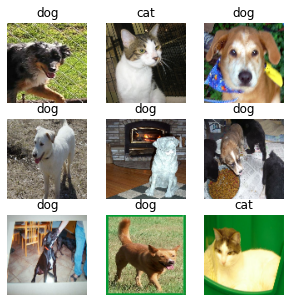

In [ ]:
# plot some samples
class_names = ["cat", "dog"]

plt.figure(figsize=(5, 5))
for i, (images, labels) in enumerate(ds.take(1)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = restore_original_image_from_array(images[i].numpy()) / 255.0
      plt.imshow(img)
      plt.title(class_names[labels[i]])
      plt.axis("off")

# Why do we use small dataset in our research works?

### Split Dataset
<img src="https://i.stack.imgur.com/pXAfX.png" width="500">


As the original dataset doesn't contain a division sets, you will create one. To do so, determine how many batches of data are available in the full_dataset set using tf.data.experimental.cardinality, then move 20% of them to a test set, the next 20% to a val set and the rest to a train set.

In [ ]:
n_batches = tf.data.experimental.cardinality(ds)
test_dataset = ds.take(n_batches // 5)
val_dataset = ds.take(2 * (n_batches // 5)).skip(n_batches // 5)
train_dataset = ds.skip(2 * (n_batches // 5))

In [ ]:
print("full_dataset: ", tf.data.experimental.cardinality(ds))
print("train: ", tf.data.experimental.cardinality(train_dataset))
print("val: ", tf.data.experimental.cardinality(val_dataset))
print("test: ", tf.data.experimental.cardinality(test_dataset))

full_dataset:  tf.Tensor(727, shape=(), dtype=int64)
train:  tf.Tensor(437, shape=(), dtype=int64)
val:  tf.Tensor(145, shape=(), dtype=int64)
test:  tf.Tensor(145, shape=(), dtype=int64)


Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [ ]:
# divide the data in train, val and tes
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.repeat(2).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Create the base model from the pre-trained convnets

You can choose to create a base model from all the models hold in tensorflow keras pre-trained model database for an easy loading. Most of the pre trained models are trained on the ImageNet dataset, then you just should specifiy the pre trained weights and which layer youn want to use in the loading function.

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.



First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

# base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
#                                          include_top=False, 
#                                          weights='imagenet')
    

(96, 96, 3)
9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `96x96x3` image into a `3x3x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


### Feature Extractor
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

**Freeze the convolutional base**

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting `layer.trainable = False`) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False     #Fill in

**Important note about BatchNormalization layers**

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains `BatchNormalization` layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

**Add a classification head - Flatten**

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)   #Fill in 
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs) 


**Compile the model**

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

#### Train the model
After training for 5 epochs, you should see ~94% accuracy on the validation set.

In [ ]:
initial_epochs = 10   #Fill in 

loss0, accuracy0 = model.evaluate(val_dataset)

145/145 [==============================] - 16s 57ms/step - loss: 0.8500 - accuracy: 0.5034


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.50


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    steps_per_epoch=63
                    )

Epoch 1/10
63/63 [==============================] - 32s 277ms/step - loss: 0.7870 - accuracy: 0.5114 - val_loss: 0.7188 - val_accuracy: 0.5347
Epoch 2/10
63/63 [==============================] - 17s 277ms/step - loss: 0.7650 - accuracy: 0.5293 - val_loss: 0.6863 - val_accuracy: 0.5672
Epoch 3/10
63/63 [==============================] - 17s 275ms/step - loss: 0.7425 - accuracy: 0.5551 - val_loss: 0.6686 - val_accuracy: 0.5802
Epoch 4/10
63/63 [==============================] - 17s 276ms/step - loss: 0.7431 - accuracy: 0.5546 - val_loss: 0.6538 - val_accuracy: 0.5957
Epoch 5/10
63/63 [==============================] - 17s 281ms/step - loss: 0.7129 - accuracy: 0.5883 - val_loss: 0.6441 - val_accuracy: 0.6093
Epoch 6/10
63/63 [==============================] - 17s 272ms/step - loss: 0.6946 - accuracy: 0.5952 - val_loss: 0.6355 - val_accuracy: 0.6207
Epoch 7/10
63/63 [==============================] - 30s 475ms/step - loss: 0.6963 - accuracy: 0.5983 - val_loss: 0.6336 - val_accuracy: 0.6394

**Learning curves**

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

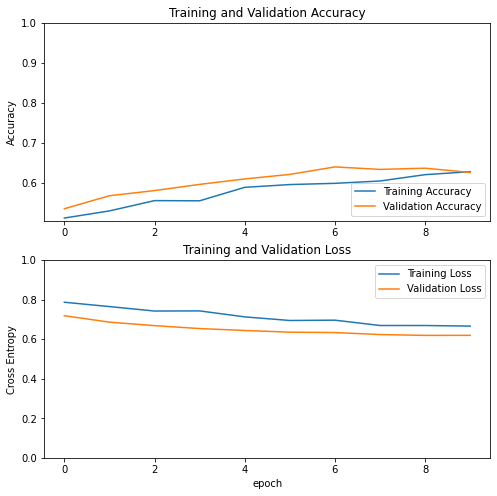

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. **In most convolutional networks, the higher up a layer is, the more specialized it is.** The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to **adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.**

**Un-freeze the top layers of the model**

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True #Fill in 

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 16    #Fill in 

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  print(layer)
  layer.trainable =  False  #Fill in 

**Compile the model**

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.



In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,220,545
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
len(model.trainable_variables)


143

**Continue training the model**

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10   #Fill in 
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         steps_per_epoch=63,
                         validation_data=val_dataset)

Epoch 10/20
63/63 [==============================] - 43s 326ms/step - loss: 0.6392 - accuracy: 0.6374 - val_loss: 0.6211 - val_accuracy: 0.6987
Epoch 11/20
63/63 [==============================] - 19s 310ms/step - loss: 0.6135 - accuracy: 0.6657 - val_loss: 0.5612 - val_accuracy: 0.6845
Epoch 12/20
63/63 [==============================] - 19s 307ms/step - loss: 0.5892 - accuracy: 0.6840 - val_loss: 0.5411 - val_accuracy: 0.7172
Epoch 13/20
63/63 [==============================] - 19s 309ms/step - loss: 0.5891 - accuracy: 0.6796 - val_loss: 0.5396 - val_accuracy: 0.6815
Epoch 14/20
63/63 [==============================] - 19s 308ms/step - loss: 0.5517 - accuracy: 0.7014 - val_loss: 0.5201 - val_accuracy: 0.7168
Epoch 15/20
63/63 [==============================] - 20s 313ms/step - loss: 0.5279 - accuracy: 0.7148 - val_loss: 0.5205 - val_accuracy: 0.7528
Epoch 16/20
63/63 [==============================] - 31s 505ms/step - loss: 0.5353 - accuracy: 0.7165 - val_loss: 0.5003 - val_accuracy:

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

After fine tuning the model nearly reaches 75% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

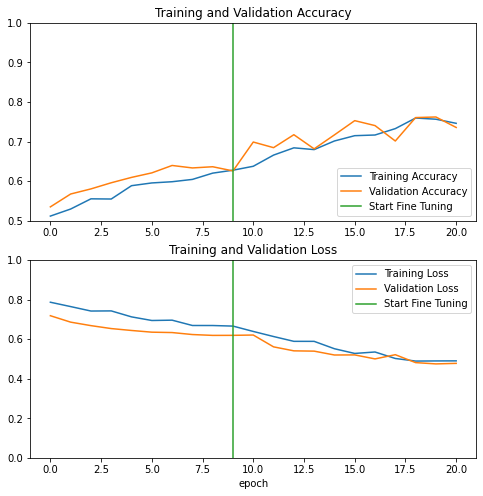

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Evaluation and prediction**

Finaly you can verify the performance of the model on new data using test set

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

145/145 [==============================] - 9s 59ms/step - loss: 0.4723 - accuracy: 0.7377
Test accuracy : 0.7377155423164368


And now you are all set to use this model to predict if your pet is a cat or dog.



Predictions:
 [1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0]
Labels:
 [1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0]


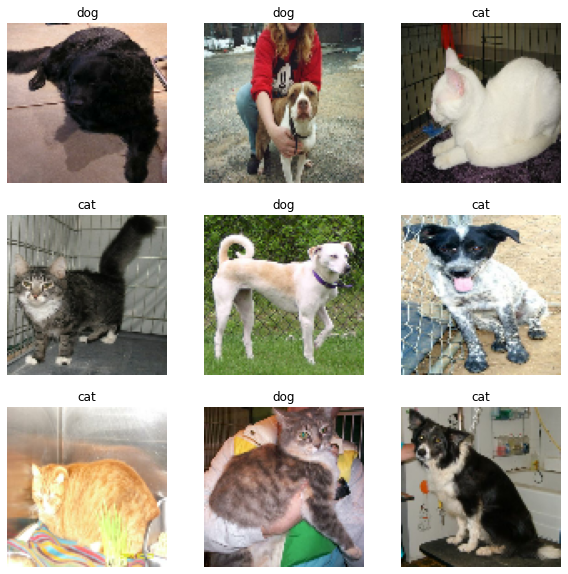

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  x = np.copy(image_batch[i])
  img = restore_original_image_from_array(x) / 255.0
  plt.imshow(img)
  plt.title(class_names[predictions[i]])
  plt.axis("off")